# density profile in wall with $\mu VT$ ensumble 
http://www.fhi-berlin.mpg.de/~luca/Course_TU/02_Metropolis_MonteCarlo.pdf

In [1]:
from numpy import random 
import numpy as np 
import math
%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt

from numba import jit

In [2]:
sigma   = 1
L =  32
dx = 1.0/8
halfL = L/2
#z=1 #exp(mu)

In [3]:
# Some helper functions
@jit
def wrap(particle):
    '''Apply perodic boundary conditions.'''
    if particle >= L:
        particle -= L
    elif particle < 0:
        particle += L
    return particle

In [4]:
@jit
def Vext_cal(x,a,b,c):
    if(x<=1):
        V=10**8
    else:
        V=0
    return V    

/home/sam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


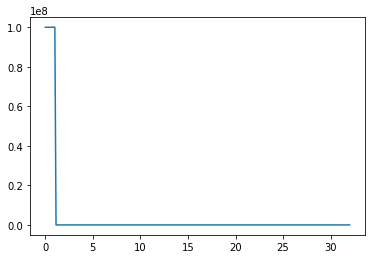

In [5]:
x= np.linspace(0,L,32//dx)
Vext = np.zeros(int(32/dx))
for i in range (int(32/dx)):
    Vext[i]=Vext_cal(i*L/32*dx,1,L/4,3)
plt.plot(x,Vext)


In [6]:
@jit
def distancesq(x1, x2):
    '''Gets the squared distance between two particles, applying the minimum image convention.'''
    # Calculate distances
    Dx = np.abs(x1-x2)
    if Dx > halfL:
        Dx -= L
    return Dx**2

In [7]:
@jit
def energy(particles,exist,epsilon,a,b,c):
    '''Gets the energy of the system'''
    energy = 0.
    
    for i in range(int(L)):
        for j in range(int(L)):
            if(i!=j and exist[i]*exist[j]==1):
                dist = distancesq(particles[i], particles[j])
                energy += 4.*epsilon*((1/dist**6)-(1/dist**3))
                if(dist<1):
                    print("Wrong!!!!")
    energy/=2
    
    for i in range(int(L)):
        if(exist[i]==1):
            energy+=Vext_cal(particles[i],a,b,c)
    
    return energy 

In [8]:
@jit
def particleEnergy(particle,p,exist, particles,epsilon,a,b,c):
    '''Gets the energy of a single particle.'''
    part_energy = 0.
    
    for i in range(int(L)):
        if(i!=p and exist[i]==1):
            dist = distancesq(particle, particles[i])
            if(dist<1):
                return 10**8
            part_energy += 4*epsilon*((1/dist**6)-(1/dist**3))
            
    
    part_energy+=Vext_cal(particle,a,b,c)
    
    return part_energy

In [9]:
# Initialize the simulation box:
@jit
def initial():
    particles = np.zeros(int(L))
    exist = np.zeros(int(L))
    for i in range(int(L)):
        #x_coord = random.uniform(0, L)
        particles[i]=i
        prop = random.uniform(0, 1)
        #if(prop>=0.5):
        #    exist[i]=1
    return particles,exist

In [10]:
@jit
def density_cal(particles,exist):
    n=int(L/dx)
    #dx=L/n
    #print(n,dx)
    rho = np.zeros(int(n),float)
    for i in range(int(L)):
        if(exist[i]==1):
            j=np.around(particles[i]//dx)
            rho[int(j)]+=1
    return rho/dx




In [11]:
@jit
def insertion(particles,z,exist,eps,a,b,c):
    for i in range (int(L)):
        if(exist[i]==0):
            particles[i] = random.uniform(0, L)
            ene = particleEnergy(particles[i],i,exist, particles,eps,a,b,c)
            prop = z*L/(np.sum(exist)+1)*np.exp(-ene)
            if(prop>=1):
                exist[i]=1
            elif(prop<1):
                dice = random.uniform(0, 1)
                if(dice<prop):
                    exist[i]=1
            break

@jit                   
def deletion(particles,z,exist,eps,a,b,c):
    M=np.random.randint(1,np.sum(exist)+1)
    cum_exist=np.cumsum(exist)
    for i in range (int(L)):
        if(exist[i]==1 and cum_exist[i]==M):
            ene = -particleEnergy(particles[i],i,exist, particles,eps,a,b,c)
            prop = np.sum(exist)/L/z*np.exp(-ene)
            if(prop>=1):
                exist[i]=0
            elif(prop<1):
                dice = random.uniform(0, 1)
                if(dice<prop):
                    exist[i]=0
            break
            

In [12]:
@jit
def MC_step(particles,z,exist,steps,eps,a,b,c,Print=True):
    for step in range(0, steps):
        prop = np.random.uniform(-0.5, 0.5)
        if(prop>0 and np.sum(exist)<L):
            insertion(particles,z,exist,eps,a,b,c)
        elif(np.sum(exist)>0):
            deletion(particles,z,exist,eps,a,b,c)
        if(step%100000==0 and Print==True):
            print(step,np.sum(exist))
    return particles,energy(particles,exist,eps,a,b,c) 

In [13]:
@jit
def MC_result(seed,z,eps,a,b,c):

    np.random.seed(seed)
    particles,exist = initial()
    "warm up"
    particles, energy = MC_step(particles,z,exist,1000,eps,a,b,c)
    avg_step = 10**6
    rho = density_cal(particles,exist)
    energy_avg=0
    N_avg=0
    ene_array = np.zeros(0)
    N_array = np.zeros(0)
    ene_array=np.append(ene_array,energy)
    N_array=np.append(N_array,np.sum(exist))
    for i in range(avg_step-1):
        np.random.seed(i)
        particles, ene = MC_step(particles,z,exist,1000,eps,a,b,c,Print=False)
        ene_array=np.append(ene_array,ene)
        N_array=np.append(N_array,np.sum(exist))
        rho += density_cal(particles,exist )
        if(i%10000==0):
            print(i,ene,np.sum(exist))
    rho=rho/avg_step
    print("energy_avg",np.sum(ene_array)/len(ene_array),
          np.sum(N_array)/len(N_array)/L)
    return rho, particles,ene_array,N_array


def density_result(seed,z,eps):
    """
    density = random.uniform(0.3,0.5)
    a=random.uniform(1,3)
    b=random.uniform(0,1)
    c=random.uniform(1,L/8)
    """
    a=0
    b=0
    c=0
    rho,particles,energy,N_array = MC_result(seed,z,eps,a,b,c)
    return rho,particles,energy,N_array

In [19]:
z = 1.5
eps = 2
rho,particles,energy_array,N_array=density_result(123,z,eps)

0 1.0
0 -7.2775598614897525 16.0
10000 -36.070272525914966 24.0
20000 -26.4268624436257 21.0
30000 -23.636389894536165 20.0
40000 -27.123937469664355 22.0
50000 -26.585158879792957 22.0
60000 -29.833463287726282 23.0
70000 -22.431648422441718 21.0
80000 -24.03895823203449 21.0
90000 -34.41943041271228 25.0
100000 -33.893701918878946 24.0
110000 -27.774560239736903 23.0
120000 -25.135703966320698 22.0
130000 -16.558058144505843 17.0
140000 -36.25865318863864 25.0
150000 -24.55627709627524 22.0
160000 -33.416905478122594 24.0
170000 -24.544073042714256 20.0
180000 -36.14912946066103 24.0
190000 -27.30073118446851 22.0
200000 -21.631116221095905 21.0
210000 -29.475129220228506 22.0
220000 -32.227831506525966 22.0
230000 -30.92862101218321 23.0
240000 -30.26725218946617 24.0
250000 -17.073115820101773 20.0
260000 -28.49952304816004 22.0
270000 -24.957148475664923 22.0
280000 -32.00723007240712 23.0
290000 -29.697275664225934 22.0
300000 -31.805255824672674 24.0
310000 -12.5052994266702 15.

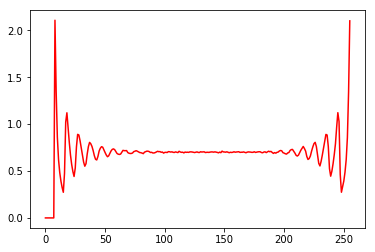

In [20]:
fig, ax1 = plt.subplots()
ax1.plot(rho,"r")

In [21]:
np.savetxt("wall_mu_ln_"+str(z)+"_eps_"+str(eps)+"_MC.dat",rho)